<a href="https://colab.research.google.com/github/xurror/365-days-of-code/blob/master/Animal_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!rm -rf data
!rm -rf downloads
!rm translate.py
!rm animals10.zip

!cp /content/drive/My\ Drive/datasets/animals10.zip /content
!unzip animals10.zip

!mv raw-img data

!rm -rf data/cane data/gatto data/farfalla data/scoiattola data/ragno data/gallina

!mv data/cavallo data/horse
!mv data/elefante data/elephant
!mv data/mucca data/cow
!mv data/pecora data/sheep
!mv data/scoiattolo data/squirrel

!du -sh data

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3Xbf3ulUg4DQ_EwHaFz.jpeg  
  inflating: raw-img/ragno/OIP-Mj15wALS_srxPktt6trhhQHaGA.jpeg  
  inflating: raw-img/ragno/OIP-Mj_JhYsl

In [4]:
import os

path, dirs, horse = next(os.walk("data/horse"))
path, dirs, elephant = next(os.walk("data/elephant"))
path, dirs, cow = next(os.walk("data/cow"))
path, dirs, sheep = next(os.walk("data/sheep"))
path, dirs, squirrel = next(os.walk("data/squirrel"))


print(len(horse))
print(len(elephant))
print(len(cow))
print(len(sheep))
print(len(squirrel))
print("\n" + str(len(horse) + len(elephant) + len(cow) + len(sheep) + len(squirrel)))

2623
1446
1866
1820
1862

9617


In [0]:
import os
import cv2
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from torchvision import transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [0]:
label_names = [
    'cow',
    'elephant',
    'horse',
    'sheep',
    'squirrel'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [0]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over our dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize(size=(224,224)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.Resize(size=(224,224)),
            transforms.CenterCrop(size=224),
            transforms.ColorJitter(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize(size=(224,224)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=train_transform)
    valid_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=valid_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False):
    """
    Utility function for loading and returning a multi-process
    test iterator over our dataset.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - data_loader: test set iterator.
    """
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return data_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


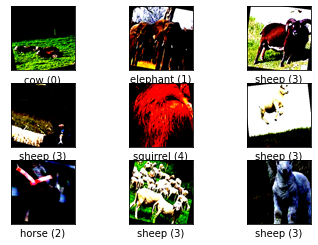

In [8]:
train_loader, valid_loader = get_train_valid_loader(data_dir="data", batch_size=32, augment=True, random_seed=8, show_sample=True)
test_loader = get_test_loader(data_dir="data", batch_size=32)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256*28*28, 1024, bias=True)
        self.relu5 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 512, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512, 5, bias=True)

        self.relu7 = nn.ReLU(inplace=True)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # print(x.shape)

        x = x.view(-1, 256*28*28)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
if use_cuda:
    net = Net().cuda()
else:
    net = Net()

In [10]:
net

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=1024, bias=True)
  (relu5): ReLU(inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu6): ReLU(inplace=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=5, bias=True)
  (relu7): ReLU(inplace=True)
  (softmax): LogSoftmax()
)

In [0]:
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = torch.optim.SGD(net.parameters(), lr = 0.003, momentum= 0.9)

In [0]:
#net.load_state_dict(torch.load('model_transfer.pt'))

In [13]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        #i = 0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        #print(f'train - output: {output}    target: {target}')
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        #print(f'valid - output: {output}    target: {target}')
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
        ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

# train the model
model_scratch = train(100, train_loader, valid_loader, net, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 1.564025 	Validation Loss: 1.458526
Validation loss decreased (inf --> 1.458526).  Saving model ...
Epoch: 2 	Training Loss: 1.475297 	Validation Loss: 1.362925
Validation loss decreased (1.458526 --> 1.362925).  Saving model ...
Epoch: 3 	Training Loss: 1.422749 	Validation Loss: 1.339651
Validation loss decreased (1.362925 --> 1.339651).  Saving model ...
Epoch: 4 	Training Loss: 1.379258 	Validation Loss: 1.271584
Validation loss decreased (1.339651 --> 1.271584).  Saving model ...
Epoch: 5 	Training Loss: 1.349204 	Validation Loss: 1.214442
Validation loss decreased (1.271584 --> 1.214442).  Saving model ...
Epoch: 6 	Training Loss: 1.296848 	Validation Loss: 1.174304
Validation loss decreased (1.214442 --> 1.174304).  Saving model ...
Epoch: 7 	Training Loss: 1.286156 	Validation Loss: 1.127059
Validation loss decreased (1.174304 --> 1.127059).  Saving model ...
Epoch: 8 	Training Loss: 1.254846 	Validation Loss: 1.125563
Validation loss decreased (1.12705

<All keys matched successfully>

In [15]:
def test(loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(test_loader, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.352133


Test Accuracy: 87% (8454/9617)


In [26]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
train_dataset = torchvision.datasets.ImageFolder(root="data")
class_names = [item for item in train_dataset.classes]
print(class_names)
model = model_scratch.cpu()
from torchvision import datasets, models, transforms
def predict_animal_class(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
    ])
    
    img = transform(img)
    img = torch.unsqueeze(img, 0)
    output = model(img)
    print(output)
    _, pred = torch.max(output, 1)
    pred_index = np.squeeze(pred.numpy()) if not use_cuda else np.squeeze(pred.cpu().numpy())
    
    return class_names[pred_index] # predicted class

print(predict_animal_class("squ1.jpg"))

['cow', 'elephant', 'horse', 'sheep', 'squirrel']
tensor([[-3.5002, -2.6444, -3.1999, -1.2843, -0.5427]],
       grad_fn=<LogSoftmaxBackward>)
squirrel


In [25]:
model_scratch

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=1024, bias=True)
  (relu5): ReLU(inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu6): ReLU(inplace=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=5, bias=True)
  (relu7): ReLU(inplace=True)
  (softmax): LogSoftmax()
)

In [1]:
!apt install neofetch
!neofetch

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  neofetch
0 upgraded, 1 newly installed, 0 to remove and 43 not upgraded.
Need to get 74.8 kB of archives.
After this operation, 365 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 neofetch all 3.4.0-1 [74.8 kB]
Fetched 74.8 kB in 1s (61.1 kB/s)
Selecting previously unselected package neofetch.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../neofetch_3.4.0-1_all.deb ...
Unpacking neofetch (3.4.0-1) ...
Setting up neofetch (3.4.0-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [2]:
!neofetch

            .-/+oossssoo+/-. 
        `:+ssssssssssssssssss+:` 
      -+ssssssssssssssssssyyssss+- 
    .ossssssssssssssssssdMMMNysssso. 
   /ssssssssssshdmmNNmmyNMMMMhssssss/ 
  +ssssssssshmydMMMMMMMNddddyssssssss+ 
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/ 
.ssssssssdMMMNhsssssssssshNMMMdssssssss. 
+sssshhhyNMMNyssssssssssssyNMMMysssssss+ 
ossyNMMMNyMMhsssssssssssssshmmmhssssssso 
ossyNMMMNyMMhsssssssssssssshmmmhssssssso 
+sssshhhyNMMNyssssssssssssyNMMMysssssss+ 
.ssssssssdMMMNhsssssssssshNMMMdssssssss. 
 /sssssssshNMMMyhhyyyyhdNMMMNhssssssss/ 
  +sssssssssdmydMMMMMMMMddddyssssssss+ 
   /ssssssssssshdmNNNNmyNMMMMhssssss/ 
    .ossssssssssssssssssdMMMNysssso. 
      -+sssssssssssssssssyyyssss+- 
        `:+ssssssssssssssssss+:` 
            .-/+oossssoo+/-. 
root@6f2ecfd47ecf 
----------------- 
OS: Ubuntu 18.04.3 LTS on Chrome OS x86_64 
Host: Google Compute Engine 
Kernel: 4.19.104+ 
Uptime: 1 min 
Packages: 1225 
Shell: bash 4.4.20 
Terminal: jupyter-noteboo 
CPU: Intel Xeon (2) @ 2.

In [0]:
!cp model_scratch.pt /content/drive/My\ Drive/datasets

In [28]:
!du -sh model_scratch.pt

788M	model_scratch.pt
